In [1]:
from numpy import random, abs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from copy import deepcopy
import datetime

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

def generate_weights_dict(num_of_agents):
    weights_dict = {}
    for i in range(0, num_of_agents):
        weights_dict[f'{i}'] = []
        weights = random.multinomial(10000, [1.0/(num_of_agents - 1)] * (num_of_agents - 1))
        index_in_weights = 0
        for j in range(0, num_of_agents):
            if i == j:
                weights_dict[f'{i}'].append(0)
            else:
                weights_dict[f'{i}'].append(weights[index_in_weights] / 10000.0)
                index_in_weights += 1
    return weights_dict

def initial_opinion_list(num_of_agents):
    return [random.uniform(0.0, 1.0) for _ in range(0, num_of_agents)]

def choose_stubborn_agents(percent_of_stubborn_agents_threshold, opinions_list):
    return [i for i in range(len(opinions_list)) if opinions_list[i] > (1 - percent_of_stubborn_agents_threshold / 2.0) or opinions_list[i] < percent_of_stubborn_agents_threshold / 2.0]

def generate_switch_agents_at_iterations(switch_agent_rate, num_iterations):
    return [0 for _ in range(num_iterations)] if switch_agent_rate is None else np.random.binomial(1, 1 / switch_agent_rate, num_iterations)

def truncate_opinion(opinion):
    if opinion > 0.999:
        return 0.999
    if opinion < 0.001:
        return 0.001
    return opinion

def update_opinion_assimilation(opinions_list, stubborn_agents, weights_dict, agent, mio):
    prev_opinion = opinions_list[agent]
    if agent in stubborn_agents:
        return prev_opinion
    neighbors_opinions = [prev_opinion_for_neighbor - prev_opinion for prev_opinion_for_neighbor in opinions_list]
    neighbors_opinions_weights_mul_sum = sum([neighbors_opinions[j] * weights_dict[f'{agent}'][j] for j in range(len(opinions_list))])
    return prev_opinion + mio * neighbors_opinions_weights_mul_sum

def print_analysis(iteration, opinions_list):
    # Calculate the point density
    xy = np.vstack([opinions_list])
    z = gaussian_kde(xy)(xy)
    plt.scatter(opinions_list, opinions_list, c=z)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(f"Opinion distribution after {int(iteration) - 1} iterations")

def print_avg_results(results, title):
    num_of_repetitions = len(results)
    iterations = results[0].keys()
    num_of_agents = len(results[0][list(iterations)[0]])
    data = []
    for iteration in iterations:
        avg_opinions_list = [sum([repetition_result[iteration][i] for repetition_result in results]) / num_of_repetitions for i in range(num_of_agents)]
        # print_analysis(iteration, avg_opinions_list)
        data.append(avg_opinions_list)

    time_steps = len(data)
    fig, ax = plt.subplots()
    def animate(i):
        fig.clear()
        ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(0, 1), ylim=(0, 1))
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.grid(b=None)
        ax.text(0.02, 0.95, 'Step = %d' % i, transform=ax.transAxes)
        ax.title.set_text(title)
        xy = np.vstack([data[i]])
        z = gaussian_kde(xy)(xy)
        s = ax.scatter(data[i], data[i], c = z) # , cmap = "RdBu_r", marker = ".", edgecolor = None
        cb = fig.colorbar(s)
        cb.remove()
    ani = animation.FuncAnimation(fig, animate, interval=1000, frames=time_steps)
    ani.save(f'{title}.gif', writer='pillow')
    plt.show()

def run_assimilation_flow(
        title,
        num_of_agents=30,
        num_iterations=5,
        scatter_every=1,
        mio=0.1,
        percent_of_stubborn_agents_threshold=0.5,
        num_of_repetitions=5,
        switch_agent_rate=None,
        switch_agent_sigma=0.2
):
    print(f"Running assimilation flow for:\n"
          f"title={title}\n"
          f"num_of_agents={num_of_agents}\n"
          f"num_iterations={num_iterations}\n"
          f"scatter_every={scatter_every}\n"
          f"mio={mio}\n"
          f"percent_of_stubborn_agents_threshold={percent_of_stubborn_agents_threshold}\n"
          f"num_of_repetitions={num_of_repetitions}"
          f"switch_agent_rate={switch_agent_rate}\n"
          f"switch_agent_sigma={switch_agent_sigma}\n")
    random.seed(10)
    results = [{} for _ in range(num_of_repetitions)]
    for repetition in range(num_of_repetitions):
        repetition_start = datetime.datetime.now()
        print(f"Starting repetition #{repetition} out of {num_of_repetitions}")
        weights_dict = generate_weights_dict(num_of_agents)
        opinions_list = initial_opinion_list(num_of_agents)
        stubborn_agents = choose_stubborn_agents(percent_of_stubborn_agents_threshold, opinions_list)
        switch_agents_at_iterations = generate_switch_agents_at_iterations(switch_agent_rate, num_iterations)
        for iteration in range(1, num_iterations):
            if iteration == 1 or (iteration + 1) % scatter_every == 0 or (iteration - 1) == num_iterations:
                to_results = sorted(deepcopy(opinions_list))
                results[repetition][f"{iteration}"] = to_results
            if switch_agents_at_iterations[iteration] == 1:
                agent_to_switch = random.choice(range(num_of_agents), replace=False)
                new_agent_opinion = truncate_opinion(random.normal(opinions_list[agent_to_switch], switch_agent_sigma))
                opinions_list[agent_to_switch] = new_agent_opinion
            opinions_list = [update_opinion_assimilation(opinions_list, stubborn_agents, weights_dict, i, mio) for i in range(num_of_agents)]
        print(f"Finished repetition #{repetition} in {(repetition_start - datetime.datetime.now()).seconds} seconds")
    print_avg_results(results, title)

def is_exposed_to_passive(radical_exposure_eta, passive_agent_opinion):
    if radical_exposure_eta is None:
        return True
    return np.random.binomial(1, radical_exposure_eta * abs(0.5 - passive_agent_opinion)) == 1

def is_similar_enough(epsilon, active_opinion, passive_opinion):
    return (-1 * epsilon) < active_opinion - passive_opinion < epsilon

def run_similarity_flow(
        title,
        num_of_agents=30,
        num_iterations=300,
        scatter_every=30,
        mio=0.4,
        num_of_repetitions=20,
        epsilon=0.1,
        switch_agent_rate=None,
        switch_agent_sigma=0.2,
        radical_exposure_eta=None
):
    print(f"Running similarity flow for:\n"
          f"title={title}\n"
          f"num_of_agents={num_of_agents}\n"
          f"num_iterations={num_iterations}\n"
          f"scatter_every={scatter_every}\n"
          f"mio={mio}\n"
          f"epsilon={epsilon}\n"
          f"num_of_repetitions={num_of_repetitions}\n"
          f"epsilon={epsilon}\n"
          f"switch_agent_rate={switch_agent_rate}\n"
          f"switch_agent_sigma={switch_agent_sigma}\n"
          f"radical_exposure_eta={radical_exposure_eta}")
    random.seed(10)
    results = [{} for _ in range(num_of_repetitions)]
    for repetition in range(num_of_repetitions):
        opinions_list = initial_opinion_list(num_of_agents)
        switch_agents_at_iterations = generate_switch_agents_at_iterations(switch_agent_rate, num_iterations)
        for iteration in range(1, num_iterations):
            if iteration == 1 or (iteration + 1) % scatter_every == 0 or (iteration - 1) == num_iterations:
                to_results = sorted(deepcopy(opinions_list))
                results[repetition][f"{iteration}"] = to_results
            if switch_agents_at_iterations[iteration] == 1:
                agent_to_switch = random.choice(range(num_of_agents), replace=False)
                new_agent_opinion = truncate_opinion(random.normal(opinions_list[agent_to_switch], switch_agent_sigma))
                opinions_list[agent_to_switch] = new_agent_opinion
            agent_i, agent_j = random.choice(range(num_of_agents), 2, replace=False)
            new_opinion_i = opinions_list[agent_i]
            new_opinion_j = opinions_list[agent_j]
            if is_similar_enough(epsilon, opinions_list[agent_i], opinions_list[agent_j]) and is_exposed_to_passive(radical_exposure_eta, opinions_list[agent_j]):
                new_opinion_i = opinions_list[agent_i] + mio * (opinions_list[agent_j] - opinions_list[agent_i])
            if is_similar_enough(epsilon, opinions_list[agent_i], opinions_list[agent_j]) and is_exposed_to_passive(radical_exposure_eta, opinions_list[agent_i]):
                new_opinion_j = opinions_list[agent_j] + mio * (opinions_list[agent_i] - opinions_list[agent_j])
            opinions_list = [new_opinion_i if k == agent_i else (new_opinion_j if k == agent_j else opinions_list[k]) for k in range(num_of_agents)]
    print_avg_results(results, title)

def run_repulsive_flow(
        title,
        num_of_agents=30,
        num_iterations=300,
        scatter_every=30,
        mio=0.4,
        num_of_repetitions=20,
        switch_agent_rate=None,
        switch_agent_sigma=0.2,
        radical_exposure_eta=None
):
    print(f"Running repulsive flow for:\n"
          f"title={title}\n"
          f"num_of_agents={num_of_agents}\n"
          f"num_iterations={num_iterations}\n"
          f"scatter_every={scatter_every}\n"
          f"mio={mio}\n"
          f"num_of_repetitions={num_of_repetitions}"
          f"switch_agent_rate={switch_agent_rate}\n"
          f"switch_agent_sigma={switch_agent_sigma}\n"
          f"radical_exposure_eta={radical_exposure_eta}")
    opinions_list = initial_opinion_list(num_of_agents)
    print_analysis(0, opinions_list)
    results = [{} for _ in range(num_of_repetitions)]
    for repetition in range(num_of_repetitions):
        switch_agents_at_iterations = generate_switch_agents_at_iterations(switch_agent_rate, num_iterations)
        for iteration in range(1, num_iterations):
            if iteration == 1 or (iteration + 1) % scatter_every == 0 or (iteration - 1) == num_iterations:
                results[repetition][f"{iteration}"] = [opinion for opinion in opinions_list]
            if switch_agents_at_iterations[iteration] == 1:
                agent_to_switch = random.choice(range(num_of_agents), replace=False)
                new_agent_opinion = truncate_opinion(random.normal(opinions_list[agent_to_switch], switch_agent_sigma))
                opinions_list[agent_to_switch] = new_agent_opinion
            agent_i, agent_j = random.choice(range(num_of_agents), 2, replace=False)
            new_opinion_i = opinions_list[agent_i]
            new_opinion_j = opinions_list[agent_j]
            if is_exposed_to_passive(radical_exposure_eta, opinions_list[agent_j]):
                new_opinion_i = truncate_opinion(opinions_list[agent_i] + mio * (1 - 2 * (abs(opinions_list[agent_j] - opinions_list[agent_i]))))
            if is_exposed_to_passive(radical_exposure_eta, opinions_list[agent_i]):
                new_opinion_j = truncate_opinion(opinions_list[agent_j] + mio * (1 - 2 * (abs(opinions_list[agent_i] - opinions_list[agent_j]))))
            opinions_list = [new_opinion_i if k == agent_i else (new_opinion_j if k == agent_j else opinions_list[k]) for k in range(num_of_agents)]
    print_avg_results(results, title)

In [2]:
# Run assimilation flow without stubborn agents

# run_assimilation_flow(
#     title="Vanilla Assimilation - Consensus",
#     num_of_agents=200,
#     num_iterations=60,
#     scatter_every=10,
#     mio=0.1,
#     percent_of_stubborn_agents_threshold=0,
#     num_of_repetitions=10,
#     switch_agent_rate=None,
#     switch_agent_sigma=None
# )

In [3]:
# Run assimilation flow with stubborn agents

# run_assimilation_flow(
#     title="Vanilla Assimilation - Stubborn Agents",
#     num_of_agents=200,
#     num_iterations=60,
#     scatter_every=10,
#     mio=0.1,
#     percent_of_stubborn_agents_threshold=0.1,
#     num_of_repetitions=10,
#     switch_agent_rate=None,
#     switch_agent_sigma=None
# )
print("Finished!")


Finished!


Running similarity flow for:
title=Vanilla Similarity
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=None
switch_agent_sigma=None
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


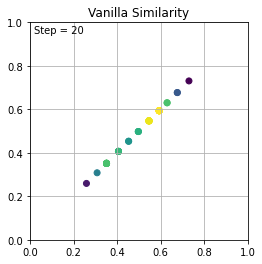

Finished!


In [4]:
run_similarity_flow(
    title="Vanilla Similarity",
    num_of_agents=50,
    num_iterations=2000,
    scatter_every=100,
    mio=0.4,
    num_of_repetitions=10,
    epsilon=0.3,
    switch_agent_rate=None,
    switch_agent_sigma=None,
    radical_exposure_eta=None
)
print("Finished!")

Running similarity flow for:
title=Similarity - Switch Agents (rate=5, std=0.2)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=5
switch_agent_sigma=0.2
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


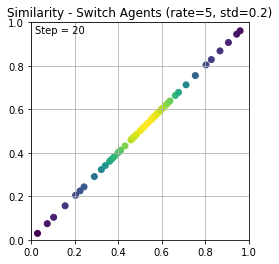

Running similarity flow for:
title=Similarity - Switch Agents (rate=5, std=0.6)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=5
switch_agent_sigma=0.6
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


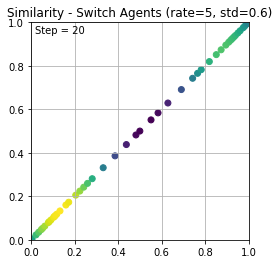

Running similarity flow for:
title=Similarity - Switch Agents (rate=10, std=0.2)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=10
switch_agent_sigma=0.2
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


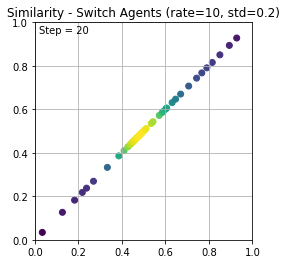

Running similarity flow for:
title=Similarity - Switch Agents (rate=10, std=0.6)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=10
switch_agent_sigma=0.6
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


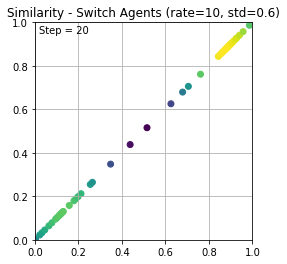

Running similarity flow for:
title=Similarity - Switch Agents (rate=30, std=0.2)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=30
switch_agent_sigma=0.2
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


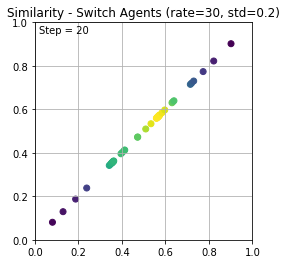

Running similarity flow for:
title=Similarity - Switch Agents (rate=30, std=0.6)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=30
switch_agent_sigma=0.6
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


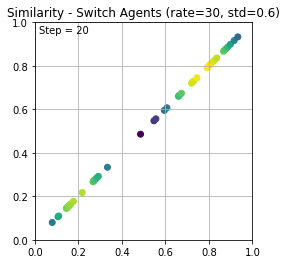

Running similarity flow for:
title=Similarity - Switch Agents (rate=100, std=0.2)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=100
switch_agent_sigma=0.2
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


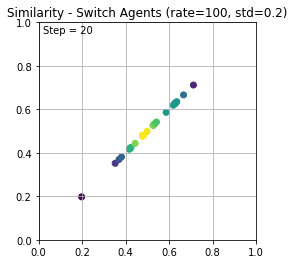

Running similarity flow for:
title=Similarity - Switch Agents (rate=100, std=0.6)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=100
switch_agent_sigma=0.6
radical_exposure_eta=None


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


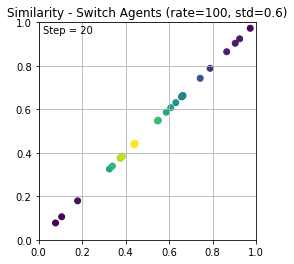

Finished!


In [5]:
switch_agent_rates = [5, 10, 30, 100]
switch_agent_sigmas = [0.2, 0.6]

for switch_agent_rate in switch_agent_rates:
    for switch_agent_sigma in switch_agent_sigmas:
        run_similarity_flow(
            title=f"Similarity - Switch Agents (rate={switch_agent_rate}, std={switch_agent_sigma})",
            num_of_agents=50,
            num_iterations=2000,
            scatter_every=100,
            mio=0.4,
            num_of_repetitions=10,
            epsilon=0.3,
            switch_agent_rate=switch_agent_rate,
            switch_agent_sigma=switch_agent_sigma,
            radical_exposure_eta=None
        )
print("Finished!")

Running similarity flow for:
title=Similarity - Radical Exposure (eta=0.2)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=None
switch_agent_sigma=None
radical_exposure_eta=0.2


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


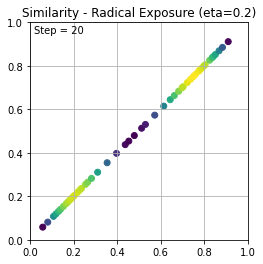

Running similarity flow for:
title=Similarity - Radical Exposure (eta=0.6)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=None
switch_agent_sigma=None
radical_exposure_eta=0.6


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


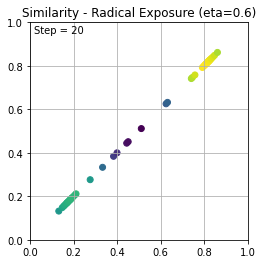

Running similarity flow for:
title=Similarity - Radical Exposure (eta=0.8)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=None
switch_agent_sigma=None
radical_exposure_eta=0.8


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


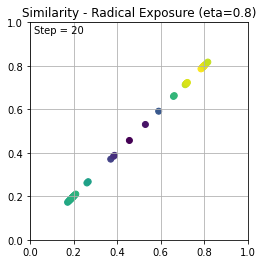

Running similarity flow for:
title=Similarity - Radical Exposure (eta=1.2)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=None
switch_agent_sigma=None
radical_exposure_eta=1.2


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


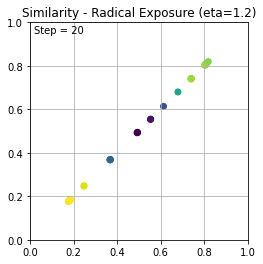

Running similarity flow for:
title=Similarity - Radical Exposure (eta=1.6)
num_of_agents=50
num_iterations=2000
scatter_every=100
mio=0.4
epsilon=0.3
num_of_repetitions=10
epsilon=0.3
switch_agent_rate=None
switch_agent_sigma=None
radical_exposure_eta=1.6


/var/folders/fr/29sr0bw966v5x6d2fg9bhkp40000gp/T/ipykernel_5456/2789393434.py:76: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


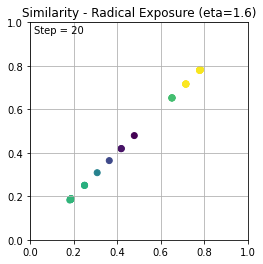

Finished!


In [6]:
etas = [0.2, 0.6, 0.8, 1.2, 1.6]
for eta in etas:
    run_similarity_flow(
        title=f"Similarity - Radical Exposure (eta={eta})",
        num_of_agents=50,
        num_iterations=2000,
        scatter_every=100,
        mio=0.4,
        num_of_repetitions=10,
        epsilon=0.3,
        switch_agent_rate=None,
        switch_agent_sigma=None,
        radical_exposure_eta=eta
    )
print("Finished!")


In [7]:
# run_repulsive_flow()
print("Finished!")

Finished!
